# 0. Prepare data


In [1]:
import json
import pickle

import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

### 0.1 Define functions

#### 0.1.1 Function to load data

In [2]:
from sklearn.feature_extraction import DictVectorizer

def load_X(dataset_path, reduced=False):
    print("Loading data (feature representation X, and feature names)...")
    # Load the reduced 10k features
    if reduced:
        with open('{}/X-10k.p'.format(dataset_path), 'rb') as f:
            X = pickle.load(f)
        with open('{}/f-10k.p'.format(dataset_path), 'rb') as f:
            feature_names = pickle.load(f)
    else:
        with open('{}/X.json'.format(dataset_path), 'r') as f:
            X = json.load(f)

        # Convert to numpy array and get feature names
        vec = DictVectorizer()
        X = vec.fit_transform(X).astype("float32")
        feature_names = vec.get_feature_names_out()

    return X, feature_names


def load_y(dataset_path):
    print('Loading labels...')
    with open('{}y.json'.format(dataset_path), 'rt') as f:
        y = json.load(f)
    y = np.asarray(y)
    return y


#### 0.1.2 Function to train a model

##### 0.1.2.1 Print Data Shapes and Distributions

In [3]:
from collections import Counter

def print_data_info(X_train, X_test, y_train, y_test, model_name):
    print(f"\n📌 Training {model_name}")
    print(f"\t🔹 X_train shape: {X_train.shape}")
    print(f"\t🔹 X_test shape: {X_test.shape}")
    print(f"\t🔹 y_train distribution: {Counter(y_train)}")
    print(f"\t🔹 y_test distribution: {Counter(y_test)}\n")

##### 0.1.2.2 Train the Model

In [4]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

##### 0.1.2.3 Calculate and Print Evaluation

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(y_test, predictions):
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    return accuracy, precision, recall, f1

def print_metrics(model_name, accuracy, precision, recall, f1, cm, roc_auc, avg_precision):
    print(f"\n   ✅ {model_name} Evaluation Metrics:")
    print(f"\t🔹 Accuracy: {accuracy:.4f}")
    print(f"\t🔹 Precision: {precision:.4f}")
    print(f"\t🔹 Recall: {recall:.4f}")
    print(f"\t🔹 F1 Score: {f1:.4f}")
    print(f"\t🔹 ROC AUC: {roc_auc:.4f}")
    print(f"\t🔹 Average Precision: {avg_precision:.4f}")
    print("\n   ✅ Confusion Matrix:")
    print(f"\t🔹 TN: {cm[0, 0]}, FP: {cm[0, 1]}")
    print(f"\t🔹 FN: {cm[1, 0]}, TP: {cm[1, 1]}\n")

##### 0.1.2.4 Calculate ROC and Precision-Recall Metrics

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

def calculate_roc_pr(y_test, y_scores):
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_scores)
    average_precision = average_precision_score(y_test, y_scores)
    return fpr, tpr, roc_auc, precision_curve, recall_curve, average_precision

##### 0.1.2.5 Plot Evaluation Results

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(model_name, fpr, tpr, roc_auc, precision_curve, recall_curve, average_precision, cm, coef=None):
    fig, axes = plt.subplots(2, 2, figsize=(20, 20))
    fig.suptitle(f'{model_name} - Performance Evaluation', fontsize=16, weight='bold')
    
    # ROC Curve
    axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 0].set_xlim([0.0, 1.0])
    axes[0, 0].set_ylim([0.0, 1.05])
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axes[0, 0].legend(loc="lower right")
    axes[0, 0].grid(True)
    
    # Precision-Recall Curve
    axes[0, 1].plot(recall_curve, precision_curve, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.4f})')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend(loc="lower left")
    axes[0, 1].grid(True)
    
    # Confusion Matrix
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=axes[1, 0])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            axes[1, 0].text(j + 0.5, i + 0.5, f'{cm[i, j]}', 
                            horizontalalignment='center', 
                            verticalalignment='center', 
                            color='black', fontsize=12)
    axes[1, 0].set_xlabel('Predicted label')
    axes[1, 0].set_ylabel('True label')
    axes[1, 0].set_title('Confusion Matrix')
    
    # Feature Importance for Linear Models
    if coef is not None:
        top_features = 20  # Show top 20 features
        # Get indices of the top positive and negative features
        top_positive_indices = np.argsort(coef)[-top_features:]
        top_negative_indices = np.argsort(coef)[:top_features]
        top_indices = np.hstack([top_negative_indices, top_positive_indices])
        
        axes[1, 1].bar(range(2 * top_features), coef[top_indices], color='r')
        axes[1, 1].set_xticks(range(2 * top_features))
        axes[1, 1].set_xticklabels(range(2 * top_features), rotation=90)
        axes[1, 1].set_xlabel('Features')
        axes[1, 1].set_ylabel('Coefficient Value')
        axes[1, 1].set_title('Top Positive and Negative Features')
    else:
        axes[1, 1].text(0.5, 0.5, "Feature Importance not available for this model", 
                        ha='center', va='center', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

##### 0.1.2.6 Integrate Everything in the Main Function

In [8]:
from sklearn.metrics import confusion_matrix

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Print data info
    print_data_info(X_train, X_test, y_train, y_test, model_name)
    
    # Train the model
    model = train_model(model, X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy, precision, recall, f1 = calculate_metrics(y_test, predictions)
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Calculate scores for ROC and Precision-Recall curves
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_scores = model.decision_function(X_test)
    
    fpr, tpr, roc_auc, precision_curve, recall_curve, average_precision = calculate_roc_pr(y_test, y_scores)
    
    # Print metrics
    print_metrics(model_name, accuracy, precision, recall, f1, cm, roc_auc, average_precision)
    
    # Feature Importance for Linear Models
    coef = model.coef_.ravel() if hasattr(model, "coef_") else None
    
    # Plot the results
    plot_results(model_name, fpr, tpr, roc_auc, precision_curve, recall_curve, average_precision, cm, coef)
    
    return model, accuracy, precision, recall, f1, roc_auc, average_precision

### 0.2 Define Classifier Models

In [14]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

def random_forest():
    """
    Initializes and returns a Random Forest classifier.
    """
    
    return RandomForestClassifier(n_estimators=100, random_state=42)

def gradient_boosting():
    """
    Initializes and returns a Gradient Boosting classifier.
    """

    return GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

def linear_support_vector_machine(max_iter=10000):
    """
    Initializes and returns a Linear Support Vector Machine classifier.
    """
    return LinearSVC(C=1, dual=True, max_iter=max_iter, random_state=42)


models = {
    "Random Forest": random_forest(),
    "Linear SVM": linear_support_vector_machine(max_iter=50000),
}

### 0.3 Prepare Dataset

#### 0.3.1 Load the data

In [11]:
# Set the path to the dataset
dataset_path = './extended-features/'

# Load the data
X, feature_names = load_X(dataset_path, reduced=False)
y = load_y(dataset_path)

## Print the shape of the data (loaded from the dataset)
print(f"\n - X Shape: {X.shape}, y Shape: {y.shape}")

Loading data (feature representation X, and feature names)...
Loading labels...

 - X Shape: (259230, 2657297), y Shape: (259230,)


#### 0.3.2 Split the data into training and testing sets

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42  # 80-20 split
)

print(f"\n - X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f" - X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")


 - X_train Shape: (207384, 2657297), y_train Shape: (207384,)
 - X_test Shape: (51846, 2657297), y_test Shape: (51846,)


# 1. Explore and evaluate different machine learning algorithms for Android malware detection

This suggests a comparative study of various ML algorithms to determine which are most effective for this specific application.

### Comparative Study of ML Algorithms

- Train various machine learning models like logistic regression, support vector machines, decision trees, random forests, gradient boosting machines, and neural networks on your dataset.
- Use cross-validation to evaluate their performance metrics (accuracy, precision, recall, F1 score, ROC-AUC, etc.).
- Perform statistical tests to determine if differences in performance are significant.



### 1.1 Train and Evaluate Models

#### 1.1.1 Random Forest

In [45]:
(
    random_forest_model,
    rf_accuracy,
    rf_precision,
    rf_recall,
    rf_f1,
) = train_and_evaluate_model(
    random_forest_model, X_train, y_train, X_test, y_test, "Random Forest"
)


📌 Training Random Forest

  ✅ Random Forest Evaluation Metrics:
    🔹 Accuracy: 0.9645
    🔹 Precision: 0.8925
    🔹 Recall: 0.7340
    🔹 F1 Score: 0.8055



#### 1.1.2 Linear SVM


📌 Training Linear SVM
	🔹 X_train shape: (207384, 2657297)
	🔹 X_test shape: (51846, 2657297)
	🔹 y_train distribution: Counter({0: 186346, 1: 21038})
	🔹 y_test distribution: Counter({0: 46497, 1: 5349})

[LibLinear]...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*......................................................................................................................................................

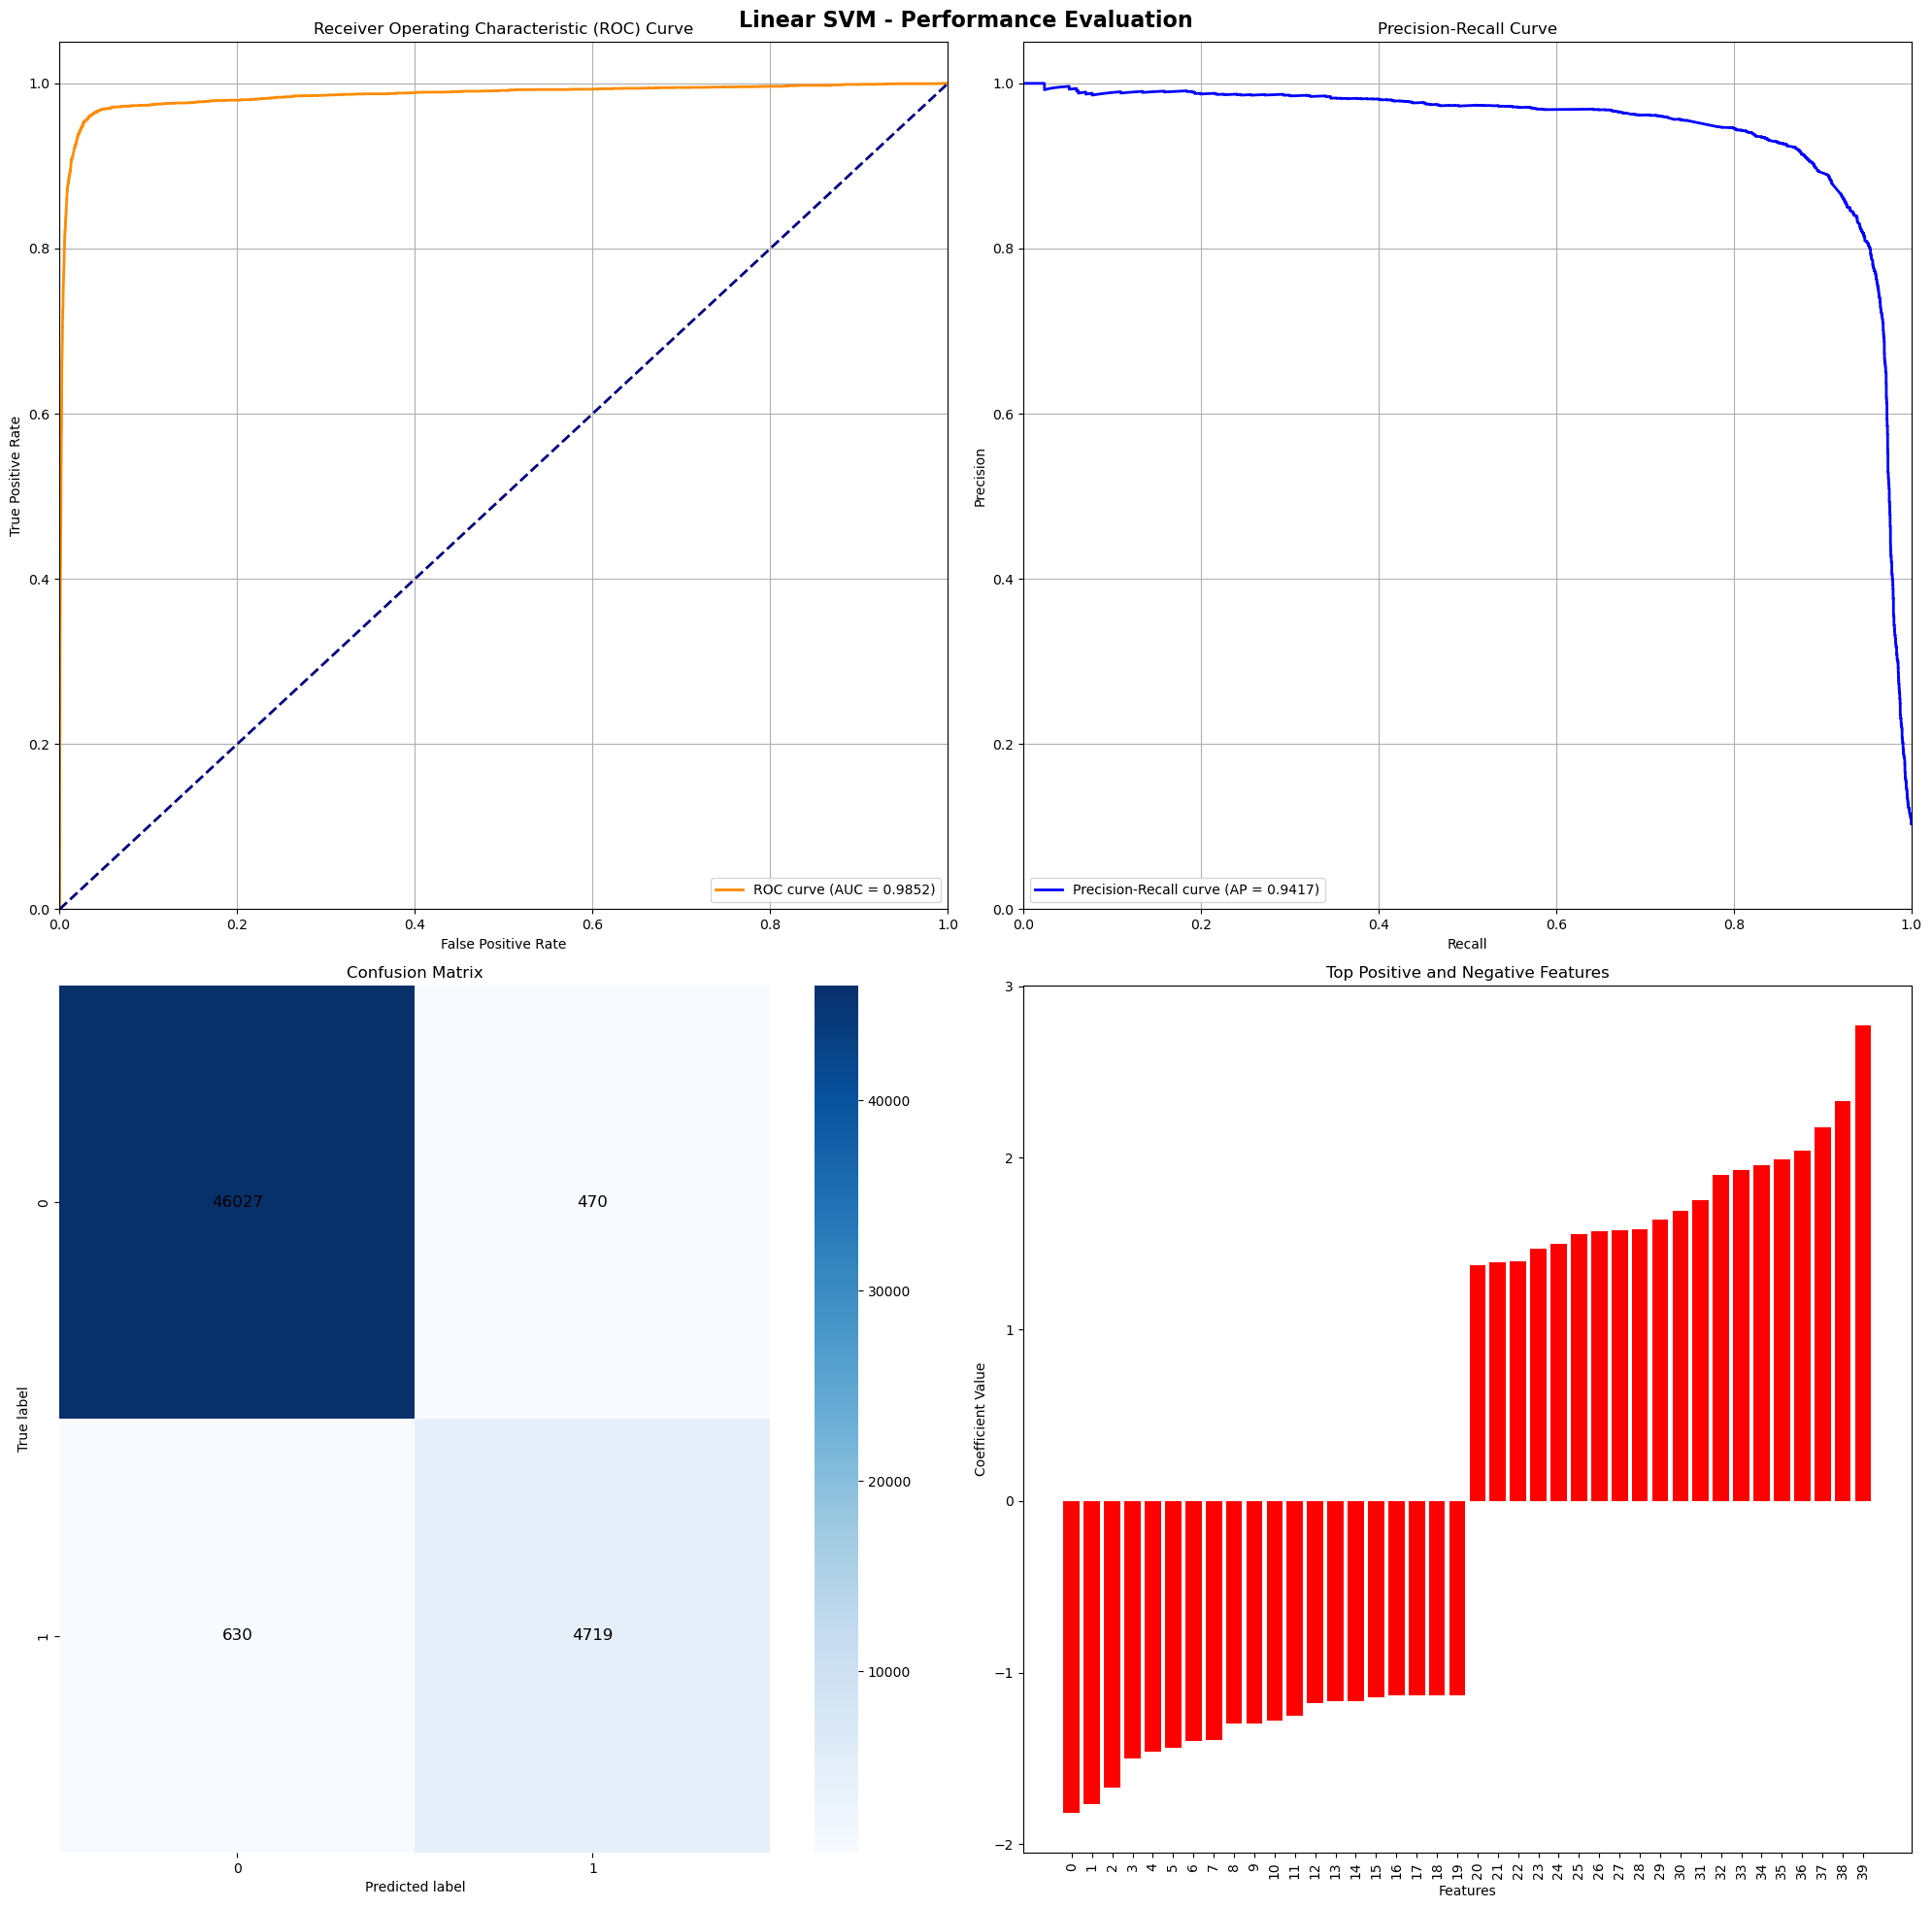

In [17]:
# Train and evaluate the Linear SVM model
(
    svm_model,
    svm_accuracy,
    svm_precision,
    svm_recall,
    svm_f1,
    svm_roc_auc,
    svm_average_precision,
) = train_and_evaluate_model(
    models.get("Linear SVM"), X_train, y_train, X_test, y_test, "Linear SVM"
)

# 2. **Verify which feature sets are most suitable for malware classification**

This involves identifying which data attributes (features) are most predictive of malware to enhance the classifier's performance.

## Feature Suitability for Malware Classification

- Use feature selection techniques like recursive feature elimination, feature importance from tree-based models, or L1 regularization to identify which features contribute most to the predictive power of the model.
- Conduct ablation studies where you systematically remove or add feature sets to see how performance is affected.
- Compare models trained on different subsets of features (e.g., API calls only, URL features only, combined features) to identify which sets or combinations are the most predictive.


### 2.1. Load original data

In [27]:
## Print the shape of the data (loaded from the dataset)

print(f"\n - X Shape: {X.shape}, y Shape: {y.shape}")


 - X Shape: (259230, 2657297), y Shape: (259230,)


### 2.2 Select features that start with 'api_calls::'

In [28]:
## 2. Select features that start with 'api_calls::'
interest = "api_calls::"
selected_indices = [
    i
    for i, feature_name in enumerate(feature_names)
    if feature_name.startswith(interest)
]

selected_feature_names = feature_names[selected_indices]

# Select data with selected features
X_selected = X[:, selected_indices]

print(f"\n - Selected Features: {len(selected_indices)}")
for name in selected_feature_names:
    print(f"    🔹 {name}")


 - Selected Features: 314
    🔹 api_calls::android/accounts/AbstractAccountAuthenticator;->checkBinderPermission
    🔹 api_calls::android/accounts/AbstractAccountAuthenticator;->getAccountRemovalAllowed
    🔹 api_calls::android/accounts/AccountManager$AmsTask;->doWork
    🔹 api_calls::android/accounts/AccountManager;->addAccount
    🔹 api_calls::android/accounts/AccountManager;->addAccountExplicitly
    🔹 api_calls::android/accounts/AccountManager;->addOnAccountsUpdatedListener
    🔹 api_calls::android/accounts/AccountManager;->blockingGetAuthToken
    🔹 api_calls::android/accounts/AccountManager;->clearPassword
    🔹 api_calls::android/accounts/AccountManager;->confirmCredentials
    🔹 api_calls::android/accounts/AccountManager;->getAccounts
    🔹 api_calls::android/accounts/AccountManager;->getAuthToken
    🔹 api_calls::android/accounts/AccountManager;->getAuthTokenByFeatures
    🔹 api_calls::android/accounts/AccountManager;->getPassword
    🔹 api_calls::android/accounts/AccountMana

### 2.3 Check if each sample (row) has at least one selected feature

In [29]:
### Check if each sample (row) has at least one selected feature
# Sum across columns (axis=1) and check if greater than 0
selected_rows = np.where(X_selected.sum(axis=1) > 0)[0]

# Indices of samples that do not contain any of the selected features
removed_rows = np.setdiff1d(np.arange(X.shape[0]), selected_rows)

# Shape of the original data
print(f"\n - Original Data Shape: {X.shape}")

# Shape of the data with selected features
print(f" - Data with Selected Features Shape: {X_selected.shape}")

# Number of samples that do not contain any of the selected features
print(f" - Number of Removed Samples: {len(removed_rows)}")

# Shape of the data after removing samples without selected features
X_selected = X_selected[selected_rows]

print(f" - Data Shape After Removing Samples: {X_selected.shape}")


 - Original Data Shape: (259230, 2657297)
 - Data with Selected Features Shape: (259230, 314)
 - Number of Removed Samples: 2139
 - Data Shape After Removing Samples: (257091, 314)


In [61]:
# Select a subset of indices to check (first one for example)
subset_indices = removed_rows[:1]

# Function to print the features of specific samples in the original data
def print_original_sample_features(
    original_data, feature_names, indices, selected_indices
):
    for idx in indices:
        print(f"\nOriginal Sample {idx}:")
        print(f"Selected Features: {original_data[idx, selected_indices].todense()}")
        print(f"All Features: {original_data[idx].todense()}")


# Print features of a subset of removed samples in the original data
print("\nSubset of Removed Samples' Features in Original Data:")
print_original_sample_features(X, feature_names, subset_indices, selected_indices)



Subset of Removed Samples' Features in Original Data:

Original Sample 257091:
Selected Features: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.

### 2.4 Split data into training and testing sets

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y[selected_rows], test_size=0.2, random_state=42  # 80-20 split
)

print(f"\n - X_train Shape: {X_train.shape}, y_train Shape: {y_train.shape}")
print(f" - X_test Shape: {X_test.shape}, y_test Shape: {y_test.shape}")


 - X_train Shape: (205672, 314), y_train Shape: (205672,)
 - X_test Shape: (51419, 314), y_test Shape: (51419,)


### 2.5 Train and evaluate models

#### 2.5.1 Random Forest

In [28]:
# (
#     random_forest_model,
#     rf_accuracy,
#     rf_precision,
#     rf_recall,
#     rf_f1,
# ) = train_and_evaluate_model(
#     random_forest_model, X_train, y_train, X_test, y_test, "Random Forest"
# )

(
    random_forest_model,
    rf_accuracy,
    rf_precision,
    rf_recall,
    rf_f1,
    rf_roc_auc,
    rf_average_precision,
) = train_and_evaluate_model(
    random_forest_model, X_train, y_train, X_test, y_test, "Random Forest"
)


📌 Training Random Forest

  ✅ Random Forest Evaluation Metrics:
    🔹 Accuracy: 0.9645
    🔹 Precision: 0.8925
    🔹 Recall: 0.7340
    🔹 F1 Score: 0.8055



#### 5.2.2 Linear Support Vector Machine


📌 Training Linear SVM
	🔹 X_train shape: (207384, 2657297)
	🔹 X_test shape: (51846, 2657297)
	🔹 y_train distribution: Counter({0: 186346, 1: 21038})
	🔹 y_test distribution: Counter({0: 46497, 1: 5349})

[LibLinear]...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................*......................................................................................................................................................

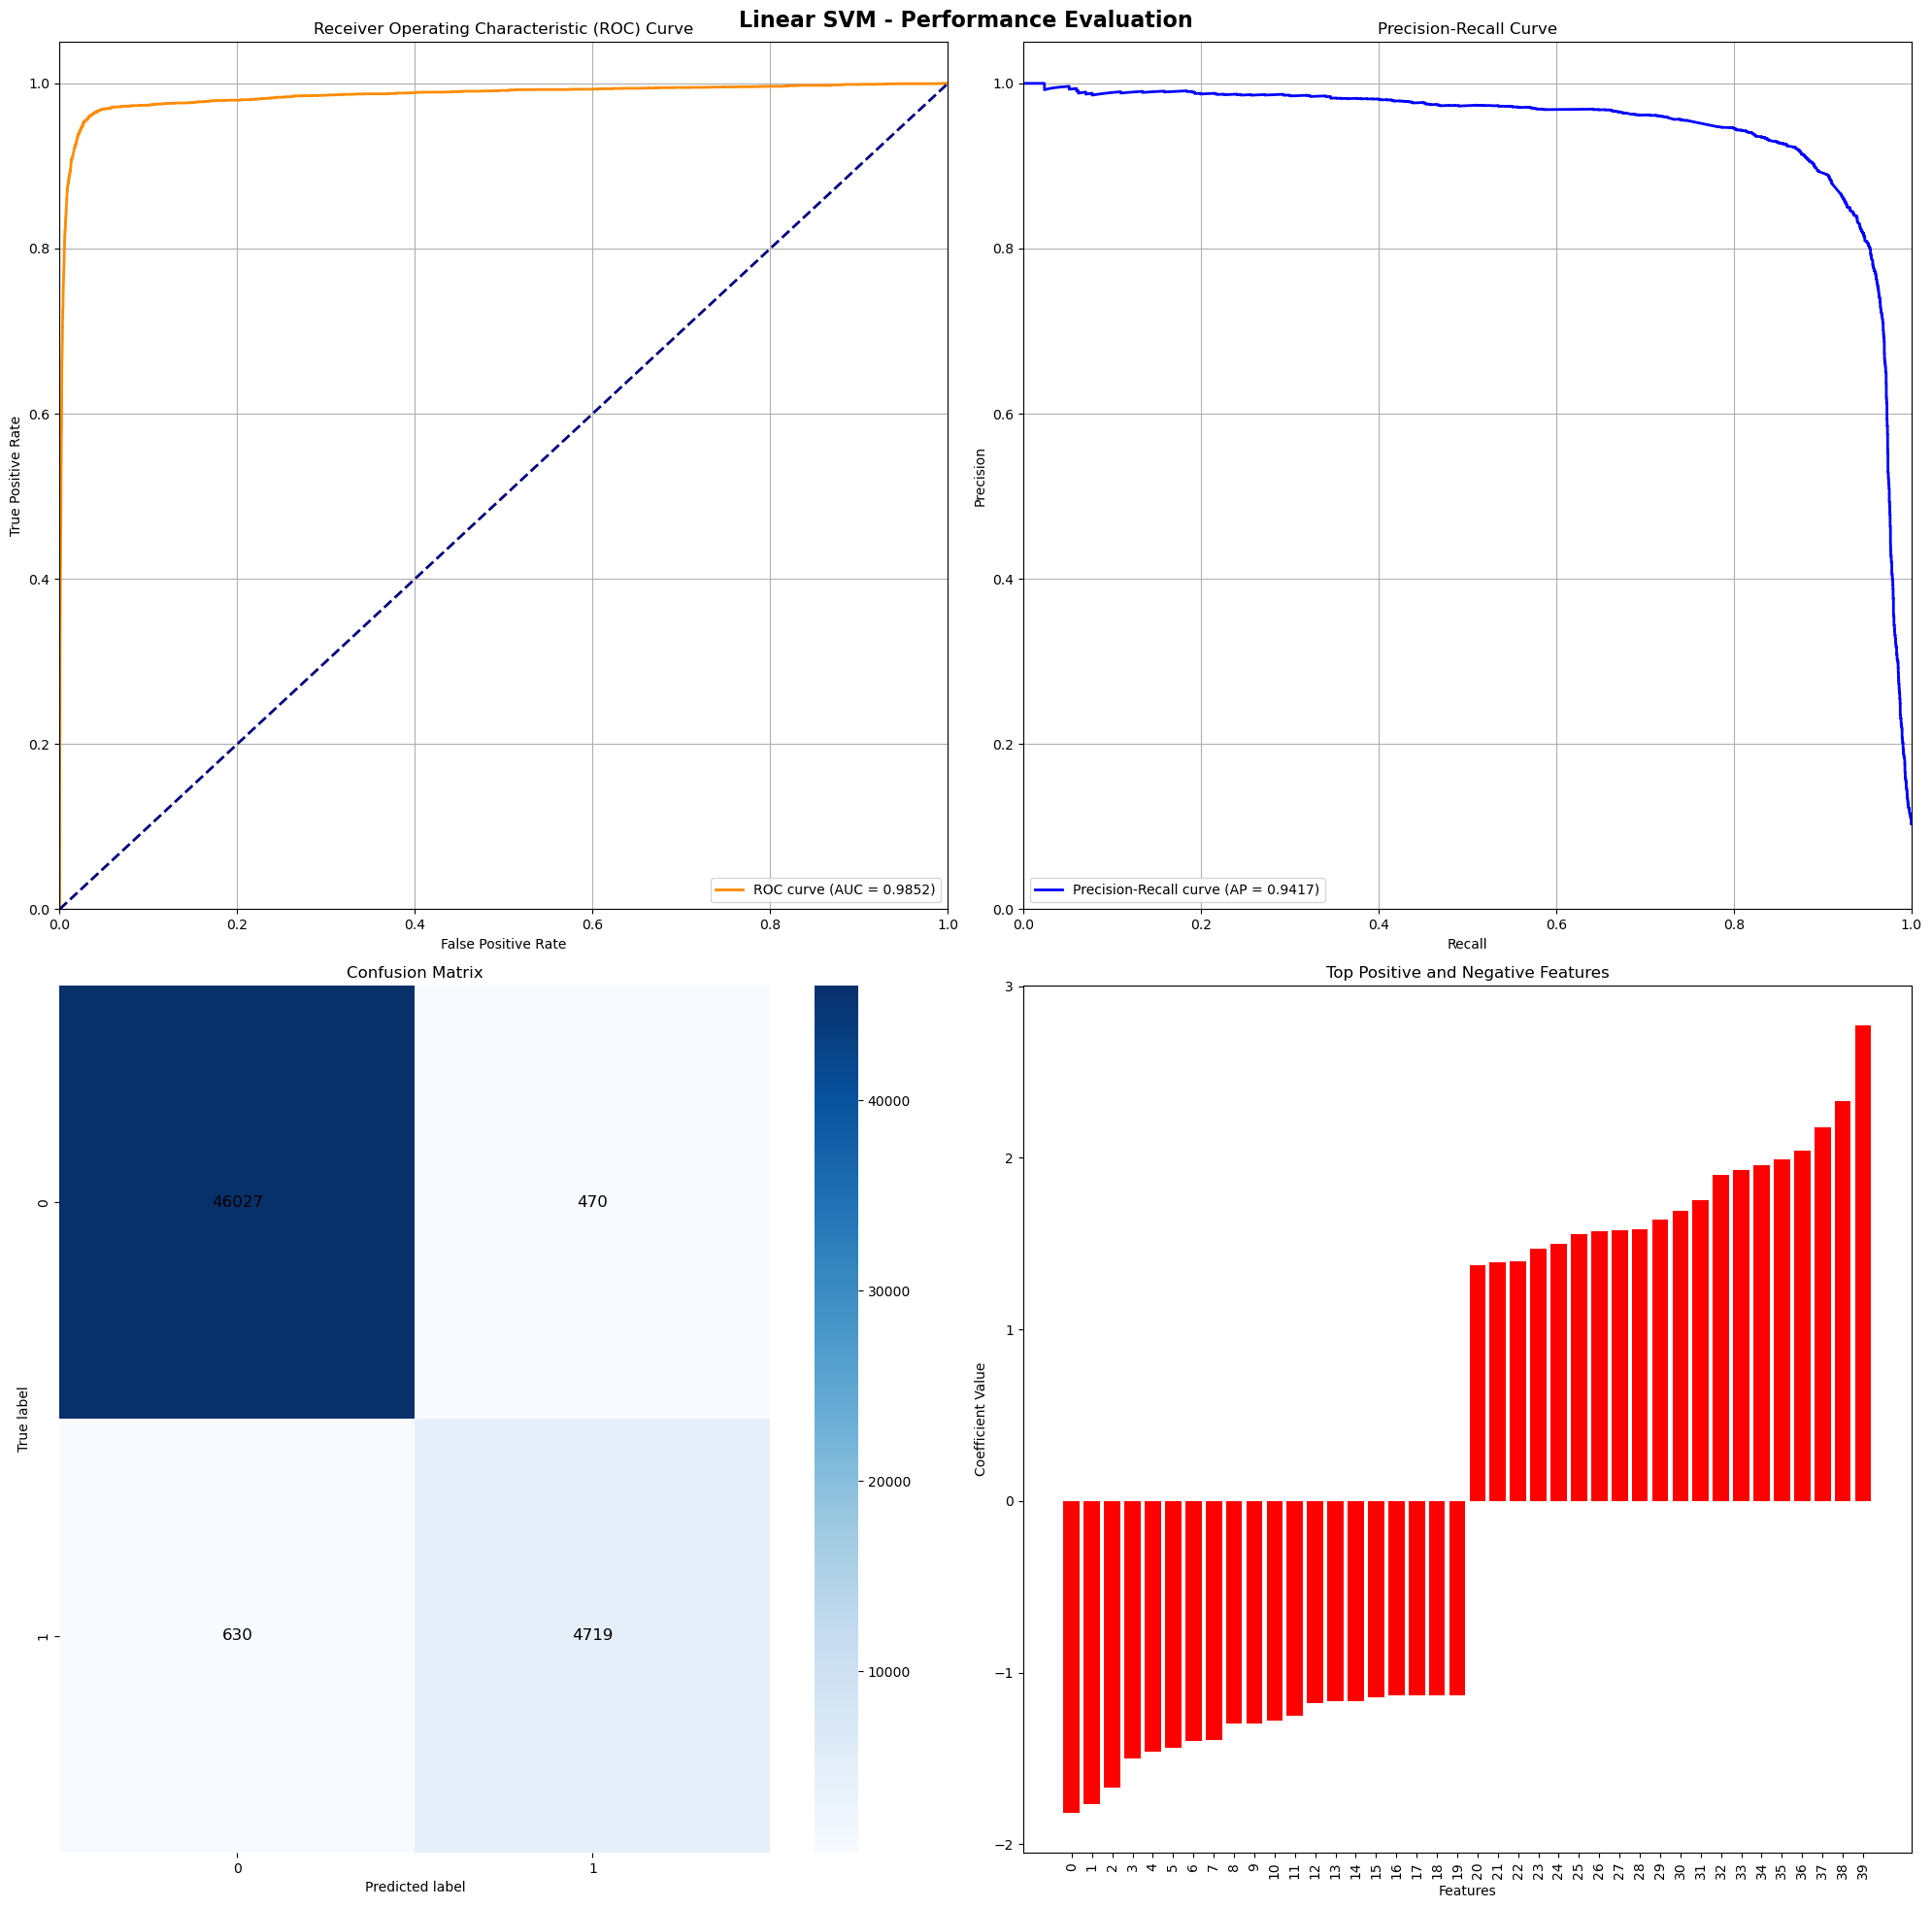

In [16]:
# Train and evaluate the Linear SVM model
(
    svm_model,
    svm_accuracy,
    svm_precision,
    svm_recall,
    svm_f1,
    svm_roc_auc,
    svm_average_precision,
) = train_and_evaluate_model(
    models.get("Linear SVM"), X_train, y_train, X_test, y_test, "Linear SVM"
)

### 2.6 Feature Importance

#### 6.1 Random Forest Feature Importance
- The higher the value, the more important the feature
- Normalize the values for better visualization

##### 6.1.1 Get the names of the top 10 most important features

In [30]:
# Ensure selected_feature_names is a NumPy array for easy indexing
selected_feature_names = np.array(selected_feature_names)

# Get feature importances from the trained Random Forest model
rf_feature_importances = random_forest_model.feature_importances_

# Normalize the values for better visualization
rf_feature_importances = 100.0 * (rf_feature_importances / rf_feature_importances.max())

# Get indices of the top 10 most important features
rf_top_indices = np.argsort(rf_feature_importances)[::-1][:10]

# Get the names of the top 10 most important features
rf_top_feature_names = selected_feature_names[rf_top_indices]


#### 6.1.2 Visualize Feature Importances

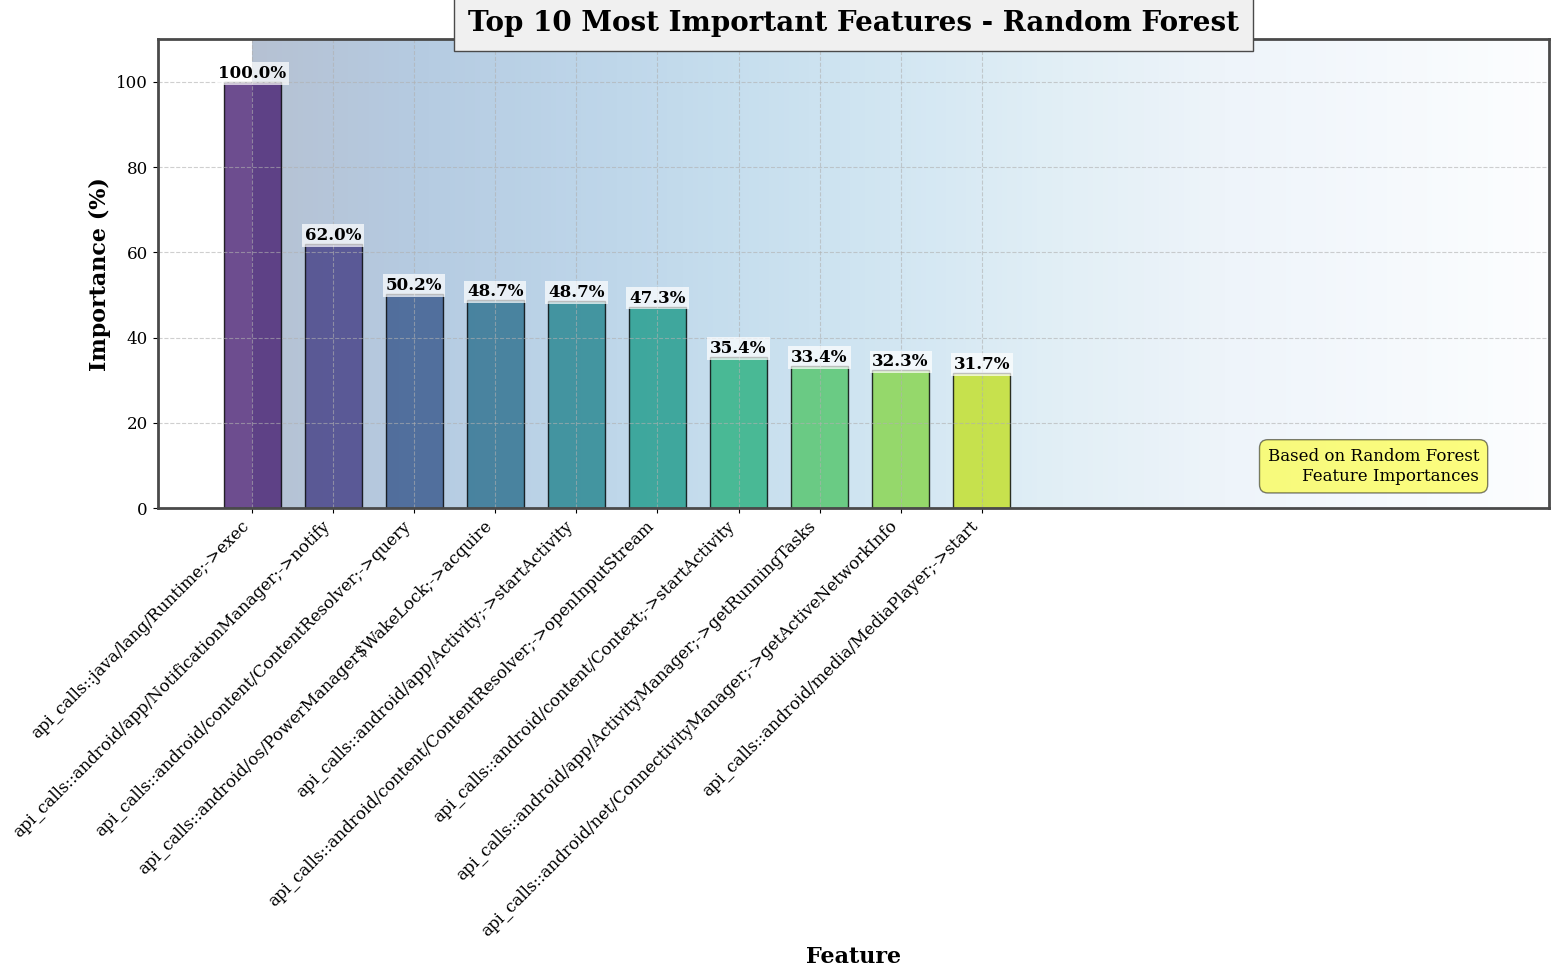

In [33]:
# Set figure size and font properties
plt.figure(figsize=(16, 10))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

# Create a gradient background
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(gradient, extent=[0, 16, 0, 110], aspect='auto', cmap='Blues_r', alpha=0.3)

# Plot the top 10 most important features
bars = plt.bar(
    rf_top_feature_names,
    rf_feature_importances[rf_top_indices],
    color=sns.color_palette("viridis", 10),
    edgecolor='black',
    align='center',
    width=0.7,
    alpha=0.8
)

# Add text annotations with improved styling
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2))

# Customize x and y axis
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Feature", fontsize=16, fontweight='bold')
plt.ylabel("Importance (%)", fontsize=16, fontweight='bold')

# Add a fancier title
plt.title("Top 10 Most Important Features - Random Forest", fontsize=20, fontweight='bold', 
          bbox=dict(facecolor='#f0f0f0', edgecolor='#4a4a4a', pad=10))

# Add a subtle grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add a border around the plot
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor("#4a4a4a")

# Add a legend-like box for extra information
plt.text(0.95, 0.05, "Based on Random Forest\nFeature Importances", transform=plt.gca().transAxes, 
         fontsize=12, va='bottom', ha='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('top_10_features_random_forest.png', format='png', dpi=300)

# Save the plot as a JPG file
plt.savefig('top_10_features_random_forest.jpg', format='jpg', dpi=300)

# Show the plot
plt.show()

#### 6.2 Linear SVM Feature Importance
- The higher the value, the more important the feature
- Normalize the values for better visualization

##### 6.2.1 Get the names of the top 10 most important features

In [36]:
# Use Seaborn for setting styles
sns.set_theme(style="darkgrid")

# Ensure selected_feature_names is a NumPy array for easy indexing
selected_feature_names = np.array(selected_feature_names)

# Get the coefficients of the Linear SVM model
svm_coefficients = np.abs(linear_svm_model.coef_)[0]

# Normalize the values for better visualization
svm_coefficients = 100.0 * (svm_coefficients / svm_coefficients.max())

# Get indices of the top 10 most important features
svm_top_indices = np.argsort(svm_coefficients)[::-1][:10]

# Get the names of the top 10 most important features
svm_top_feature_names = selected_feature_names[svm_top_indices]

#### 6.2.2 Visualize Feature Importances

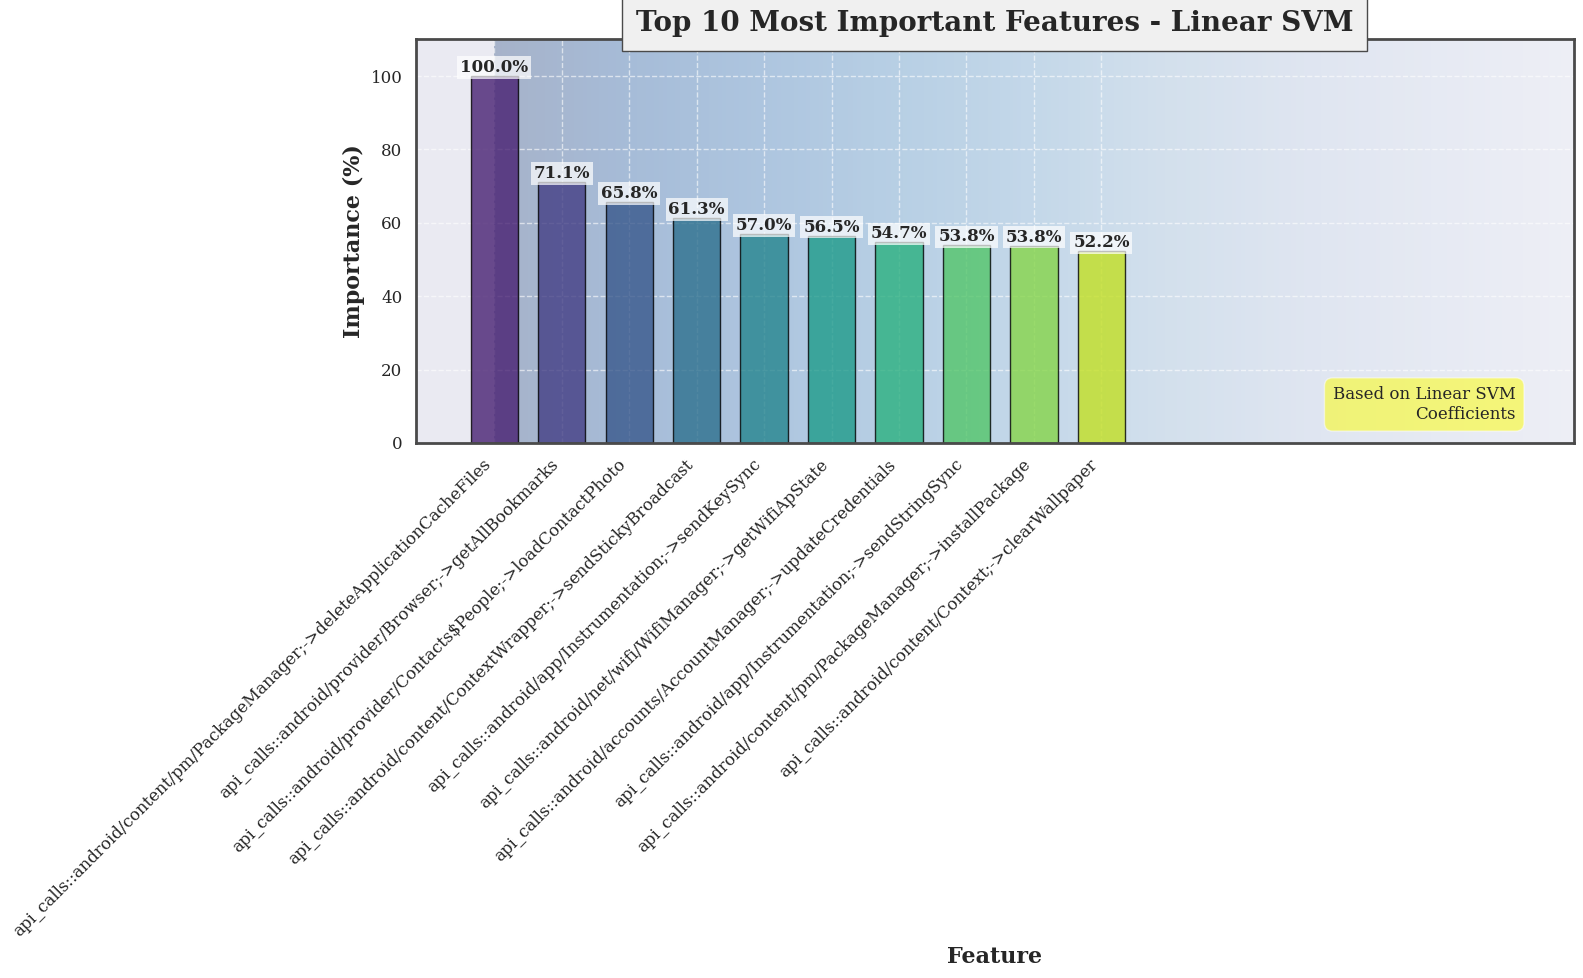

In [37]:
# Set figure size and font properties
plt.figure(figsize=(16, 10))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 14

# Create a gradient background
gradient = np.linspace(0, 1, 256).reshape(1, -1)
plt.imshow(gradient, extent=[0, 16, 0, 110], aspect='auto', cmap='Blues_r', alpha=0.3)

# Plot the top 10 most important features
bars = plt.bar(
    svm_top_feature_names,
    svm_coefficients[svm_top_indices],
    color=sns.color_palette("viridis", 10),
    edgecolor='black',
    align='center',
    width=0.7,
    alpha=0.8
)

# Add text annotations with improved styling
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.1f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold', 
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=2))

# Customize x and y axis
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Feature", fontsize=16, fontweight='bold')
plt.ylabel("Importance (%)", fontsize=16, fontweight='bold')

# Add a fancier title
plt.title("Top 10 Most Important Features - Linear SVM", fontsize=20, fontweight='bold', 
          bbox=dict(facecolor='#f0f0f0', edgecolor='#4a4a4a', pad=10))

# Add a subtle grid
plt.grid(True, linestyle='--', alpha=0.6)

# Add a border around the plot
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(2)
    spine.set_edgecolor("#4a4a4a")

# Add a legend-like box for extra information
plt.text(0.95, 0.05, "Based on Linear SVM\nCoefficients", transform=plt.gca().transAxes, 
         fontsize=12, va='bottom', ha='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.5))

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig('top_10_features_linear_svm.png', format='png', dpi=300)

# Save the plot as a JPG file
plt.savefig('top_10_features_linear_svm.jpg', format='jpg', dpi=300)

# Show the plot
plt.show()

# 3. **Explore how explanation methods can support the design and improvement of classification algorithms**

This points to the use of explanation methods, such as SHAP, to interpret ML models' decisions, possibly to increase their transparency and trustworthiness.

This project focuses on how existing explanation methods could support a better understanding of what the classifier is learning. A known problem in the literature is indeed "shortcut learning", i.e., learning information not related to actual maliciousness. For example, a network intrusion detection algorithm may be learning that "large volumes of outgoing bytes" are an attack, but this is clearly overfitting the task. Explanations methods to be explored include (see [2]): SHAP, LIME, LEMNA, LRP.


## Use of Explanation Methods to Support Model Design:

- Apply SHAP or LIME to your models to get explanations for individual predictions, which can provide insights into what features are driving the model’s decisions for each class.
- Use global feature importance derived from SHAP to understand overall model behavior and identify which features are generally most impactful across all predictions.
- Based on the insights from SHAP, iterate on your model design, potentially simplifying models by removing less important features or engineering new features to improve clarity and performance.


### 1. Prepare Samples

In [43]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import issparse

# Increase the sample size for more comprehensive analysis
sample_size = 100

# Prepare background and test samples
background_sample = shap.sample(X_train, sample_size)
random_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
X_test_sample = X_test[random_indices]

# Convert sparse matrices to dense if necessary
if issparse(background_sample):
    background_sample = background_sample.toarray()
if issparse(X_test_sample):
    X_test_sample = X_test_sample.toarray()

# Filter features related to 'api_calls::'
api_calls_features = [feature for feature in selected_feature_names if feature.startswith('api_calls::')]
api_calls_indices = [i for i, feature in enumerate(selected_feature_names) if feature.startswith('api_calls::')]
X_test_api_calls = X_test_sample[:, api_calls_indices]

# Initialize SHAP explainers
rf_explainer = shap.TreeExplainer(random_forest_model)
svm_explainer = shap.KernelExplainer(linear_svm_model.decision_function, background_sample)

# Compute SHAP values
rf_shap_values = rf_explainer.shap_values(X_test_sample)
svm_shap_values = svm_explainer.shap_values(X_test_sample)

# Function to plot and save SHAP summary plots
def plot_and_save_shap_summary(shap_values, X, feature_names, model_name, plot_type="bar"):
    plt.figure(figsize=(20, 12))
    shap.summary_plot(shap_values, X, feature_names=feature_names, plot_type=plot_type, show=False)
    plt.title(f"{model_name} - SHAP Summary Plot ({plot_type.capitalize()} Type)")
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_shap_summary_{plot_type}.png', dpi=300, bbox_inches='tight')
    plt.close()

# Generate and save SHAP summary plots for both models
plot_and_save_shap_summary(rf_shap_values, X_test_sample, selected_feature_names, "Random Forest")
plot_and_save_shap_summary(rf_shap_values, X_test_sample, selected_feature_names, "Random Forest", "violin")
plot_and_save_shap_summary(svm_shap_values, X_test_sample, selected_feature_names, "Linear SVM")
plot_and_save_shap_summary(svm_shap_values, X_test_sample, selected_feature_names, "Linear SVM", "violin")

# Function to analyze top features based on SHAP values
def analyze_top_features(shap_values, feature_names, top_n=10):
    feature_importance = np.abs(shap_values).mean(0)
    top_indices = feature_importance.argsort()[-top_n:][::-1]
    return [(feature_names[i], feature_importance[i]) for i in top_indices]

# Analyze top features for both models
rf_top_features = analyze_top_features(rf_shap_values, selected_feature_names)
svm_top_features = analyze_top_features(svm_shap_values, selected_feature_names)

print("Top 10 features based on SHAP values:")
print("\nRandom Forest:")
for feature, importance in rf_top_features:
    print(f"{feature}: {importance:.4f}")

print("\nLinear SVM:")
for feature, importance in svm_top_features:
    print(f"{feature}: {importance:.4f}")

# Generate SHAP dependence plots for top features
def plot_dependence(shap_values, X, feature_names, model_name):
    top_features = analyze_top_features(shap_values, feature_names, top_n=5)
    for feature, _ in top_features:
        plt.figure(figsize=(12, 8))
        shap.dependence_plot(feature, shap_values, X, feature_names=feature_names, show=False)
        plt.title(f"{model_name} - SHAP Dependence Plot for {feature}")
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_dependence_{feature.replace("::", "_")}.png', dpi=300, bbox_inches='tight')
        plt.close()

plot_dependence(rf_shap_values, X_test_sample, selected_feature_names, "Random Forest")
plot_dependence(svm_shap_values, X_test_sample, selected_feature_names, "Linear SVM")

# Analyze misclassifications
y_test_sample = y_test[random_indices]
rf_predictions = random_forest_model.predict(X_test_sample)
svm_predictions = linear_svm_model.predict(X_test_sample)

def analyze_misclassifications(shap_values, X, y_true, y_pred, feature_names, model_name):
    misclassified = y_true != y_pred
    mis_shap = shap_values[misclassified]
    mis_X = X[misclassified]
    
    plt.figure(figsize=(20, 12))
    shap.summary_plot(mis_shap, mis_X, feature_names=feature_names, plot_type="bar", show=False)
    plt.title(f"{model_name} - SHAP Summary for Misclassified Samples")
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_misclassified_summary.png', dpi=300, bbox_inches='tight')
    plt.close()

analyze_misclassifications(rf_shap_values, X_test_sample, y_test_sample, rf_predictions, selected_feature_names, "Random Forest")
analyze_misclassifications(svm_shap_values, X_test_sample, y_test_sample, svm_predictions, selected_feature_names, "Linear SVM")

# Print conclusions
print("\nConclusions:")
print("1. The SHAP analysis reveals the most influential features for both Random Forest and Linear SVM models.")
print("2. There are similarities and differences in feature importance between the two models, which could inform feature engineering efforts.")
print("3. The dependence plots show how specific features interact with the model's predictions, potentially revealing non-linear relationships.")
print("4. Analysis of misclassified samples highlights which features contribute most to errors, guiding further model improvements.")
print("5. This explanation method supports the design and improvement of classification algorithms by providing interpretable insights into model behavior.")

ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. Consider retrying with the feature_perturbation='interventional' option. This check failed because for one of the samples the sum of the SHAP values was -6009.402436, while the model output was 0.985282. If this difference is acceptable you can set check_additivity=False to disable this check.

In [10]:
shap.initjs()

# Decide Sample Size
sample_size = 100

# Reduce the number of background samples
background_sample = shap.sample(X_train, sample_size)

# Randomly select 100 indices from the test data
random_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)

# Select the rows corresponding to these indices from the sparse matrix
X_test_sample = X_test[random_indices]

# Filter features related to 'api_calls::'
api_calls_features = [feature for feature in feature_names if feature.startswith('api_calls::')]
api_calls_indices = [i for i, feature in enumerate(feature_names) if feature.startswith('api_calls::')]

# Filter X_test for these features
X_test_api_calls = X_test[:, api_calls_indices]

In [11]:

    # Decide Sample Size
    sample_size = 1000
    
    # Reduce the number of background samples
    background_sample = shap.sample(X_train, sample_size)
    
    # Randomly select 100 indices from the test data
    random_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
    
    # Select the rows corresponding to these indices from the sparse matrix
    X_test_sample = X_test[random_indices]
    
    # Create an Explainer instance
    explainer = shap.Explainer(linear_svm, background_sample)
    
    # Compute SHAPley Value
    shap_values = explainer(X_test_sample)


    # Filter features related to 'api_calls::'
    api_calls_features = [feature for feature in feature_names if feature.startswith('api_calls::')]
    api_calls_indices = [i for i, feature in enumerate(feature_names) if feature.startswith('api_calls::')]
    
    # Filter X_test for these features
    X_test_api_calls = X_test[:, api_calls_indices]
    
    # Filter SHAP values and X_test for these features
    shap_values_api_calls = shap_values[:, api_calls_indices]



### 2-1. Explainer for Random Forest

In [12]:
# Create an Explainer instance
explainer = shap.KernelExplainer(random_forest.predict_proba, background_sample)

# # Compute SHAPley Value
shap_values = explainer(X_test_sample)

Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Filter SHAP values and X_test for these features
shap_values_api_calls = shap_values[:, api_calls_indices]


# Generate summary plot for 'api_calls::' features
plt.figure(figsize=(20, 10))  # Adjust the size as needed
shap.summary_plot(shap_values_api_calls, X_test_api_calls, feature_names=api_calls_features)

plt.show()

### 2-2. Explainer for Linear SVC

In [17]:
# Create an Explainer instance
explainer = shap.Explainer(linear_svm, background_sample)

# Compute SHAPley Value
shap_values = explainer(X_test_sample)

# Filter SHAP values and X_test for these features
shap_values_api_calls = shap_values[:, api_calls_indices]

#### 2-2-1. Summary Plot: All

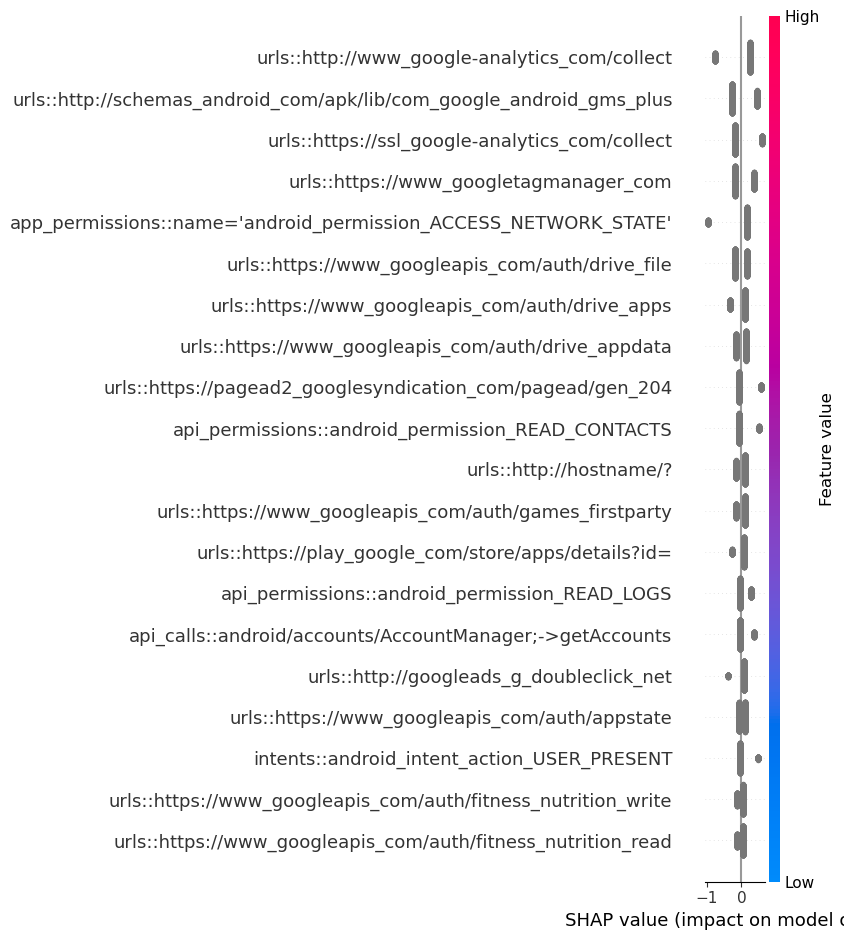

In [16]:
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names)

#### 2-2-2. Summary Plot: Bar type

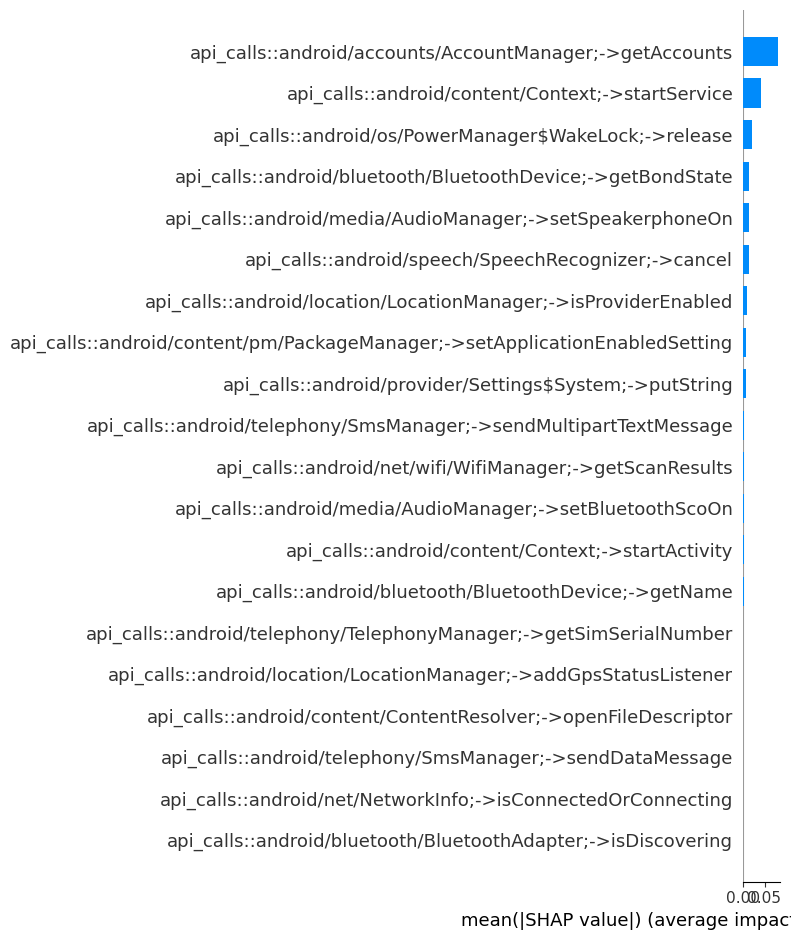

In [19]:
shap.summary_plot(shap_values_api_calls, X_test_api_calls, feature_names=api_calls_features, plot_type="bar")